In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


class XDistGen(object):
    def __init__(self, dist, dim=2):
        self.dim = dim
        self.dist = dist
        
    def __call__(self, samples):
        return self.dist.rvs(size=(samples, self.dim))

    def pdf(self, x):
        return self.dist.pdf(x).prod(axis=1)


class YGen1(object):
    def __init__(self, dim=3):
        self.dim = dim

    def __call__(self, x):
        y = np.zeros((x.shape[0], self.dim))
        y[:, 0] = 1/(1 + np.exp(-x[:, 0] + 1)) / 2 + 0.5
        y[:, 1] = (1 - 1/(1 + np.exp(-x[:, 1] - 1)))
        y[:, 2] = (1 - 1/(1 + np.exp(-x[:, 1] - 3)))
        return y
    
class YGen2(object):
    def __init__(self, dim=3):
        self.dim = dim

    def __call__(self, x):
        y = YGen1(dim=self.dim)(x)
        #y[:, 2] = 1/(1 + np.exp(-(x[:, 0] + x[:, 1])))
        y[:, 2] = 1/(1 + np.exp(-x[:, 0] + 2))
        return y

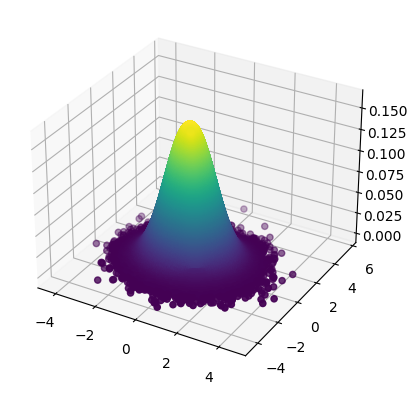

In [2]:
samples = 100000
x_gen = XDistGen(stats.norm, dim=2)
x = x_gen(samples)
x_prob = x_gen.pdf(x)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x[:,0], x[:,1], x_prob, c=x_prob, cmap='viridis')

In [3]:
y1 = YGen1(dim=3)(x)
y2 = YGen2(dim=3)(x)

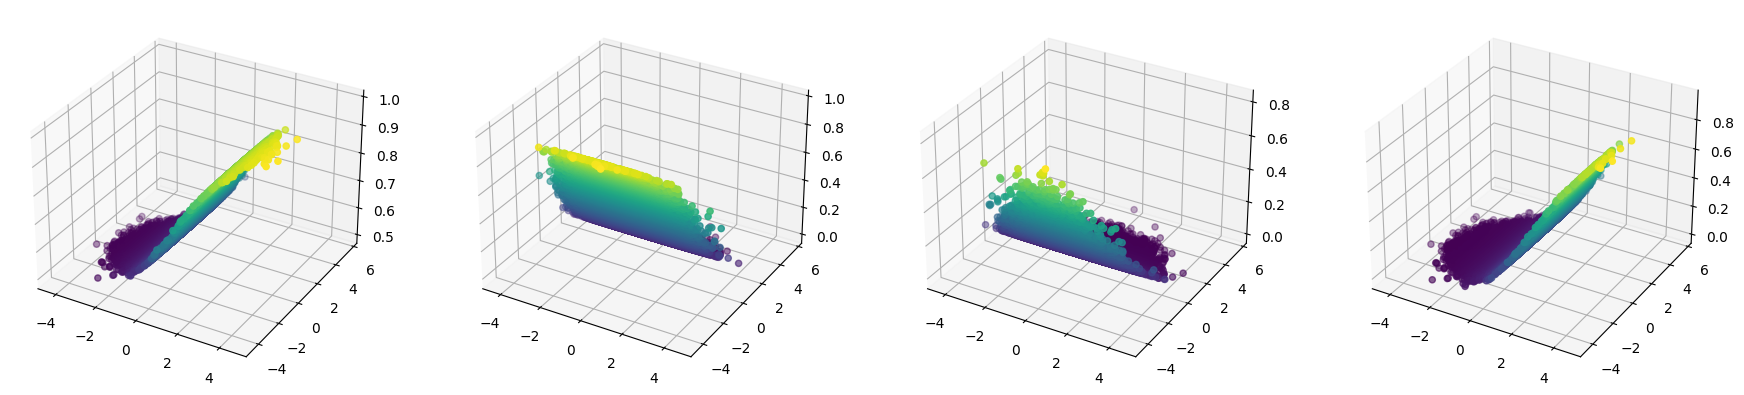

In [4]:
fig = plt.figure(figsize=(22, 5))
ax = fig.add_subplot(1, 4, 1, projection='3d')
ax.scatter(x[:,0], x[:,1], y1[:,0], c=y1[:,0], cmap='viridis')
ax = fig.add_subplot(1, 4, 2, projection='3d')
ax.scatter(x[:,0], x[:,1], y1[:,1], c=y1[:,1], cmap='viridis')
ax = fig.add_subplot(1, 4, 3, projection='3d')
ax.scatter(x[:,0], x[:,1], y1[:,2], c=y1[:,2], cmap='viridis')
ax = fig.add_subplot(1, 4, 4, projection='3d')
ax.scatter(x[:,0], x[:,1], y2[:,2], c=y2[:,2], cmap='viridis')

In [5]:
from pathlib import Path
import os
import sys
sys.path.append(os.path.dirname(Path.cwd()))
from src.frank_wolfe import frank_wolfe, select_top_k_np, macro_sqrt_tp_C, macro_f1_C


def get_order(y_proba, classifiers, classifier_weights, seed=0):
    if seed is not None:
        np.random.seed(seed)

    ni = y_proba.shape[0]
    result = np.zeros(y_proba.shape)
    for i in range(ni):
        c = np.random.choice(classifiers.shape[0], p=classifier_weights)
        G = classifiers[c]
        eta_i = y_proba[i]
        u = (eta_i * (G[:,0] - G[:,1] - G[:,2] + G[:,3])) + G[:,1] - G[:,3]
        result[i] = u

    return result


def get_fw_order01(y, utlity_func):
    classifiers, classifiers_weights, meta = frank_wolfe(y, y, utlity_func, max_iters=100, k=1)
    y_pred = get_order(y, classifiers, classifiers_weights, seed=0)
    order = y_pred[:,0] > y_pred[:,1]
    return order, y_pred


In [6]:
order1, y_pred1 = get_fw_order01(y1, macro_f1_C)
order2, y_pred2 = get_fw_order01(y2, macro_f1_C)

Starting Frank-Wolfe algorithm
  Calculating initial utility based on topk predictions ...
    y_true: (100000, 3), y_pred: (100000, 3), y_proba: (100000, 3)
    initial utility: 33.69142711162567
  Starting iteration 1 ...
    utility = 0.3369142711162567
    new a = [0.4195407 1.822242  9.617008 ]
    new b = [-0.16218047 -0.21649083  0.        ]
    utility_i = 0.09688685089349747
    alpha = 0.073
  Starting iteration 2 ...
    utility = 0.34926876425743103
    new a = [0.43677706 1.8453174  4.880277  ]
    new b = [-0.16410922 -0.20580187 -0.17885685]
    utility_i = 0.36628761887550354
    alpha = 0.505
  Starting iteration 3 ...
    utility = 0.3899671137332916
    new a = [0.5403873 0.9849669 5.8641033]
    new b = [-0.16794902 -0.21453097 -0.33045185]
    utility_i = 0.3517493009567261
    alpha = 0.315
  Starting iteration 4 ...
    utility = 0.40302637219429016
    new a = [0.5223259 1.1604725 3.844902 ]
    new b = [-0.16838822 -0.21617876 -0.36862212]
    utility_i = 0.446

In [7]:
y_pred1

array([[ 0.15869294,  0.17272034, -0.24191518],
       [ 0.12606947,  0.11629641, -0.3202165 ],
       [ 0.15516562,  0.15732491, -0.26424808],
       ...,
       [ 0.27469194,  0.32297427,  0.02485433],
       [ 0.1371088 ,  0.03448333, -0.41848732],
       [ 0.16142888,  0.07971875, -0.36617406]])

In [8]:
y_pred2

array([[ 0.18213585,  0.15378105, -0.11347661],
       [ 0.14798523,  0.09541317, -0.26883565],
       [ 0.17844341,  0.13785521, -0.13177332],
       ...,
       [ 0.30356492,  0.30921162,  0.83643679],
       [ 0.15954132,  0.01078141, -0.21956172],
       [ 0.1850789 ,  0.05745803, -0.09900315]])

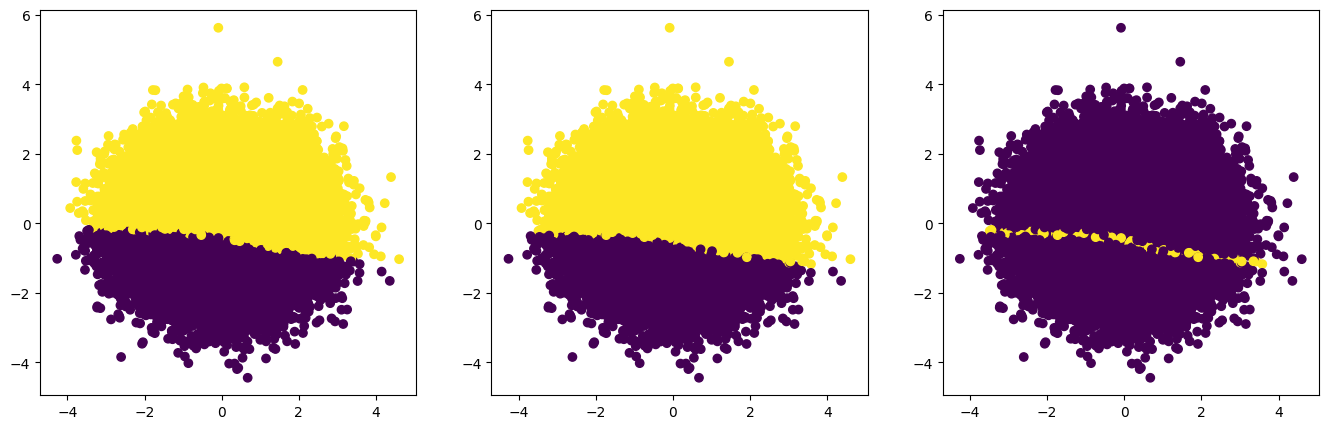

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5))
diff = order1 != order2
axes[0].scatter(x[:,0], x[:,1], c=order1, cmap='viridis')
axes[1].scatter(x[:,0], x[:,1], c=order2, cmap='viridis')
axes[2].scatter(x[:,0], x[:,1], c=diff, cmap='viridis')